In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Read in the data
df = pd.read_csv("data_train.csv")
df = df.drop('Id', axis=1)  # Drop useless Id column (it is not a predictor)
label = "SalePrice"    # The column that contains the label to predict.

# One-hot encode the neighborhoods before we do train/test split (in case some neighborhoods are only in one of the sets)
df = pd.concat([df, pd.get_dummies(df.Neighborhood, prefix='Neighborhood', dtype=int)], axis=1)
df = pd.concat([df, pd.get_dummies(df.Condition1, prefix = 'Condition1', dtype=int)], axis=1)
df = pd.concat([df, pd.get_dummies(df.Condition1, prefix = 'Condition2', dtype=int)], axis=1)
df = pd.concat([df, pd.get_dummies(df.SaleType, prefix = 'BldgType', dtype=int)], axis=1)
df = pd.concat([df, pd.get_dummies(df.SaleCondition, prefix = 'SaleCondition', dtype=int)], axis=1)

# Split into train and test
train, test = train_test_split(df, test_size=.2, random_state=12)


Train R^2: 85%
Train RMSE = 30282
Test R^2: 83%
Test RMSE = 32461
Prediction: 490165 vs actual 184750
Top 20 features by cost
	GrLivArea: 180592 = (4676.0 * 38.62))
	OverallQual: 101026 = (10.0 * 10102.63))
	BsmtQual: 46636 = (4.0 * 11659.09))
	BsmtFinSF: 46468 = (2260.0 * 20.56))
	KitchenQual: 41034 = (4.0 * 10258.47))
	GarageCars: 31408 = (3.0 * 10469.17))
	OverallCond: 28025 = (5.0 * 5605.10))
	StreetPaved: 22988 = (1.0 * 22987.79))
	TotalBaths: 21706 = (4.5 * 4823.61))
	TotRmsAbvGrd: 21607 = (11.0 * 1964.26))
	GarageQual: 18993 = (2.0 * 9496.68))
	LotArea: 18475 = (40094.0 * 0.46))
	ExterQual: 18420 = (4.0 * 4604.93))
	KitchenAbvGr: -17596 = (1.0 * -17595.57))
	BldgType_New: 16387 = (1.0 * 16386.66))
	MasVnrArea: 12906 = (762.0 * 16.94))
	BsmtUnfSF: 10772 = (878.0 * 12.27))
	Neighborhood_Edwards: -9799 = (1.0 * -9798.77))
	WoodDeckSF: 5147 = (208.0 * 24.75))
	SaleCondition_Partial: -4572 = (1.0 * -4572.34))
Original features
	MSSubClass: 20
	MSZoning: RL
	LotFrontage: nan
	LotArea:

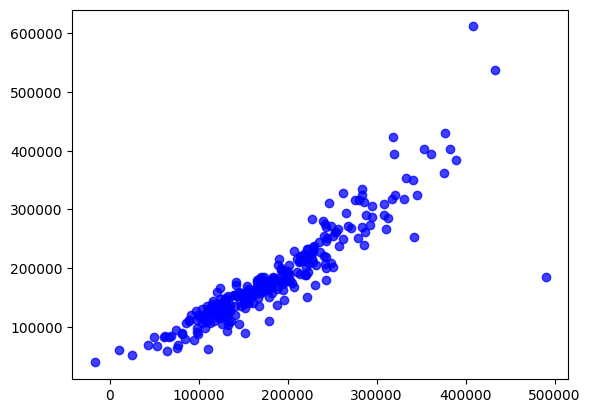


Top features by magnitude of coefficient
Neighborhood_NoRidge    47338.987630
Neighborhood_StoneBr    45607.857616
Neighborhood_NridgHt    36902.756922
BldgType_Oth            23605.847871
StreetPaved             22987.793650
                            ...     
KitchenAbvGr           -17595.565862
Neighborhood_NPkVill   -20849.849475
Neighborhood_BrDale    -20887.940435
BldgType_ConLw         -27339.844641
Neighborhood_Blueste   -30366.106905
Length: 86, dtype: float64


In [2]:
# Linear model
def lm_transform(df):
    # One-hot encode various categorical features
    df["PartialSalesCondition"] = df.SaleCondition.apply(lambda x: 1 if x == 'Partial' else 0)  # Partial sales are more expensive
    df["CentralAir"] = df["CentralAir"].map({'Y':1, 'N':0}, na_action='ignore')                 # Central air adds $500 (not much, but it helps)
    df["ZoneCommercial"] = df["MSZoning"].apply (lambda x: 1 if x == 'C (all)' else 0)
    df["StreetPaved"] = df["Street"].apply (lambda x: 1 if x == 'Pave' else 0)
    df["UtilitiesAll"] = df["Utilities"].apply(lambda x: 1 if x == "AllPub" else 0)

    # Convert 'quality' categorical features into numeric features
    for col_name in ['ExterQual', 'KitchenQual', 'GarageQual', 'BsmtQual']:
        df[col_name] = df[col_name].map({'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}, na_action='ignore')
        assert df[col_name].isnull().sum() < .1 * df.shape[0], f"{col_name} still has {int(df[col_name].isnull().sum()/df.shape[0] * 100)}% nulls)"
        df[col_name].fillna(2, inplace=True)
        assert np.issubdtype(df[col_name], np.number), f"{col_name} is not a number"

    # Drop all non-numeric columns
    df = df.select_dtypes(include=[np.number])

    # Impute missing values
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())
    df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["GarageYrBlt"].mean())
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    assert df.isnull().sum().sum() == 0, f"Still have {df.isnull().sum().sum()} nulls"

    # Drop the individual bathroom predictors and replace with a total bathroom predictor, which has better price correlation
    if "TotalBaths" not in df.columns:
        df["TotalBaths"] = df["FullBath"] + .5* df["HalfBath"] + df["BsmtFullBath"] + .5 * df["BsmtHalfBath"]
    df.drop(["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"], axis=1, inplace=True)

    # Convert YearBuilt and YearRemodAdd to AgeSinceRemod to prevent linear model into Year values
    df["AgeSinceRemod"] = 2024 - df["YearRemodAdd"]
    df["BsmtFinSF"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]


    """ Drop predictors for which there seems to be no price correlation"""
    predictors = ["YrSold", "MoSold", "GarageYrBlt"]        # Useless
    predictors += ["YearBuilt", "YearRemodAdd"]             # Model uses these values too much, creating outliers. Use derived AgeSinceRemod instead.
    predictors += ["1stFlrSF", "2ndFlrSF", "LowQualFinSF"]  # Duplicative of GrLivArea
    predictors += ["BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF"] # Duplicative of BsmtFinSF and BsmtUnfSF
    predictors += ["BedroomAbvGr"]                          # Negative correlation with price can't be right; duplicative of TotRmsAbvGrd
    predictors += ["MSSubClass"]                            # Categorical (shouldn't be numeric) and no good correlation
    predictors += ["GarageArea", "PoolArea", "EnclosedPorch"]  #Negative correlation with price can't be right; duplicative of GarageCars, PoolQual, and other porch predictors


    for predictor in predictors:
        df.drop(predictor, axis=1, inplace=True)

    """ Some predictors have extreme values that don't make a difference, so truncation will create a better linear model """
    # TotRmsAbvGrd - linear increase stops at 11
    df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'].apply(lambda x: 11 if x > 11 else x)
    # GarageCars; cap at 3
    df['GarageCars'] = df['GarageCars'].apply(lambda x: 3 if x > 3 else x)
    # TotalBaths capped at 4.5
    df['TotalBaths'] = df['TotalBaths'].apply(lambda x: 4.5 if x > 4.5 else x)
    # KitchenAbvGr; 1 is best, more are worse, 0 is the same as 2
    df['KitchenAbvGr'] = df['KitchenAbvGr'].apply(lambda x: 2 if x == 0 else x)

    return df

LOG_PREDICTIONS = False

lm = linear_model.LinearRegression()

lm_train = train.copy(deep=True)
lm_test = test.copy(deep=True)
if LOG_PREDICTIONS:
    lm_train[label] = np.log(lm_train[label])
    lm_test[label] = np.log(lm_test[label])
lm_train = lm_transform(lm_train)
lm_test = lm_transform(lm_test)

x_train = lm_train.drop([label], axis=1)
y_train = lm_train[label]
x_test = lm_test.drop([label], axis=1)
y_test = lm_test[label]

lm.fit(x_train, y_train)

print (f"Train R^2: {int(lm.score(x_train, y_train) * 100)}%")
predictions = lm.predict(x_train)
if LOG_PREDICTIONS:
    predictions = np.exp(predictions)
    y_train = np.exp(y_train)
rmse = mean_squared_error(y_train, predictions)**.5
print(f"Train RMSE = {rmse:.0f}")

print (f"Test R^2: {int(lm.score(x_test, y_test) * 100)}%")
predictions = lm.predict(x_test)
if LOG_PREDICTIONS:
    predictions = np.exp(predictions)
    y_test = np.exp(y_test)
rmse = mean_squared_error(y_test, predictions)**.5
print(f"Test RMSE = {rmse:.0f}")

for i, (yhat, y) in enumerate(zip(predictions, y_test)):
    if (np.abs(yhat - y) > 6*rmse):
        print (f"Prediction: {yhat:.0f} vs actual {y:.0f}")
        cost = {}
        explainer = {}
        for j, (col, coef) in enumerate(zip(x_test.columns, lm.coef_)):
            cost[col] = x_test.iloc[i][j] * coef
            explainer[col] = f"{x_test.iloc[i][j]} * {coef:.2f}"
        print ("Top 20 features by cost")
        for col, cost in sorted(cost.items(), key=lambda x: np.abs(x[1]), reverse=True)[:20]:
            print (f"\t{col}: {cost:.0f} = ({explainer[col]}))")
        print ("Original features")
        for col in test.columns:
            print (f"\t{col}: {train.iloc[i][col]}")


import matplotlib.pyplot as plt
plt.scatter(predictions, y_test, alpha=.75, color='b')
plt.show()

# Show the feature coefficients sorted by magnitude
print ("\nTop features by magnitude of coefficient")
coef = pd.Series(lm.coef_, index = x_train.columns)
print (coef.sort_values(ascending=False))

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
from sklearn.metrics import r2_score


# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

2023-08-22 13:30:09.074770: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 13:30:09.223316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 13:30:09.738541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-08-22 13:30:12.868997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 13:30:12.949723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 13:30:12.950075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 13:30:12.952726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 13:30:12.953146: I tensorflow/compile

Use /tmp/tmpr8_e7t3d as temporary training directory
Random forest


[INFO 23-08-22 13:30:16.0533 PDT kernel.cc:1243] Loading model from path /tmp/tmpr8_e7t3d/model/ with prefix 632a6252ed6f433f
[INFO 23-08-22 13:30:16.1104 PDT decision_forest.cc:660] Model loaded with 300 root(s), 100472 node(s), and 70 input feature(s).
[INFO 23-08-22 13:30:16.1104 PDT abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-22 13:30:16.1104 PDT kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Out of bag RMSE: 0
Validation R2 = 0.894, RMSE = 86506

Gradient Boosted trees


Use /tmp/tmpp18qgufp as temporary training directory


[WARNING 23-08-22 13:30:17.1047 PDT gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-22 13:30:17.1047 PDT gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-22 13:30:17.1047 PDT gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-08-22 13:30:18.1276 PDT kernel.cc:1243] Loading model from path /tmp/tmpp18qgufp/model/ with prefix 2ed11015391a4c05
[INFO 23-08-22 13:30:18.1296 PDT kernel.cc:1075] Use fast generic engine


Out of bag RMSE: 0
Validation R2 = 0.894, RMSE = 86506

Ensamble


Validation R2 = 0.909, RMSE = 62134


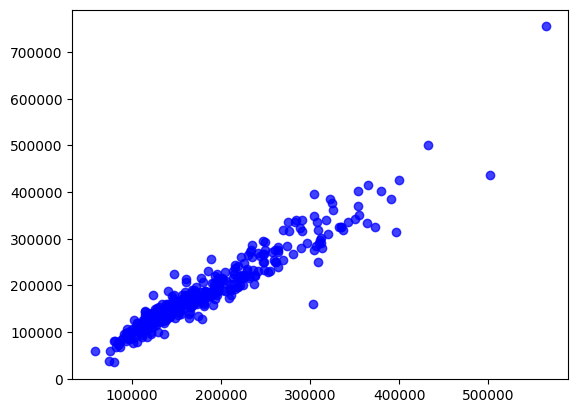

In [4]:
# For reproducability
tf.random.set_seed(12)
np.random.seed(12)

LOG_PREDICTIONS = True
def rf_transform(df):
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0) # Fill nulls with 0, since by default keras imputation is mean

    # Drop the individual bathroom predictors and replace with a total bathroom predictor, which has better price correlation
    df["TotalBaths"] = df["FullBath"] + .5* df["HalfBath"] + df["BsmtFullBath"] + .5 * df["BsmtHalfBath"]
    df.drop(["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"], axis=1, inplace=True)
  
    return df

df = pd.read_csv("data_train.csv")
df = df.drop('Id', axis=1)  # Drop useless Id column (it is not a predictor)
label = "SalePrice"    # The column that contains the label to predict.

if LOG_PREDICTIONS:
    df[label] = np.log(df[label])
df = rf_transform(df)

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]
train, valid = split_dataset(df)

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid, label=label, task = tfdf.keras.Task.REGRESSION)

rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

print ("Random forest")
rf.fit(train_ds, verbose=0)
logs = rf.make_inspector().training_logs()
print(f"Out of bag RMSE: {logs[-1].evaluation.rmse:.0f}")
ytrue = np.array(valid[label])
yhat = rf.predict(valid_ds, verbose=0).flatten()
if LOG_PREDICTIONS:
    ytrue = np.exp(ytrue)
    yhat = np.exp(yhat)
r2 = r2_score(ytrue, yhat)
rmse = ((yhat-ytrue).sum()**2/len(yhat))**.5
print(f"Validation R2 = {r2:.3f}, RMSE = {rmse:.0f}")

print ("\nGradient Boosted trees")
gb = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)
gb.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics
gb.fit(train_ds, verbose=0)
inspector = gb.make_inspector()
logs = inspector.training_logs()
print(f"Out of bag RMSE: {logs[-1].evaluation.rmse:.0f}")
yhat = rf.predict(valid_ds, verbose=0).flatten()
if LOG_PREDICTIONS:
    yhat = np.exp(yhat)
r2 = r2_score(ytrue, yhat)
rmse = ((yhat-ytrue).sum()**2/len(yhat))**.5
print(f"Validation R2 = {r2:.3f}, RMSE = {rmse.item():.0f}")

print ("\nEnsamble")
def ensemble(x):
    g = gb.predict(x, verbose=0)
    r = rf.predict(x, verbose=0)
    return (g+r) / 2

yhat = ensemble(valid_ds).flatten()
if LOG_PREDICTIONS:
    yhat = np.exp(yhat)
r2 = r2_score(ytrue, yhat)
rmse = ((yhat-ytrue).sum()**2/len(yhat))**.5
print(f"Validation R2 = {r2:.3f}, RMSE = {rmse.item():.0f}")

import matplotlib.pyplot as plt
plt.scatter(yhat, ytrue, alpha=.75, color='b')
plt.show()
